<a href="https://colab.research.google.com/github/adimyth/datascience_stuff/blob/master/machine-learning/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The space spanned by the basis vectors in PCA is the same as the space spanned by the basis vectors of AutoEncoder even though the basis vectors might themselves be different.

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.linalg import matmul
from tensorflow.keras.metrics import mean_squared_error

In [0]:
sns.set_style("whitegrid")

**Plotting Function**

In [0]:
def plot(X, title=""):
    h, w = 5, 5
    f = plt.figure(figsize=(6, 6))
    gs = f.add_gridspec(h, w)
    f.suptitle(title, fontsize=20)

    for i in range(h):
        for j in range(w):
            ax = f.add_subplot(gs[i, j])
            plt.imshow(X[i*h+j].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    f.tight_layout(rect=[0, 0.03, 1, 0.9])

**MNIST Dataset**

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
X_train = X_train/255.0
X_test = X_test/255.0

In [0]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [7]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [8]:
X_test.shape, y_test.shape

((10000, 784), (10000,))

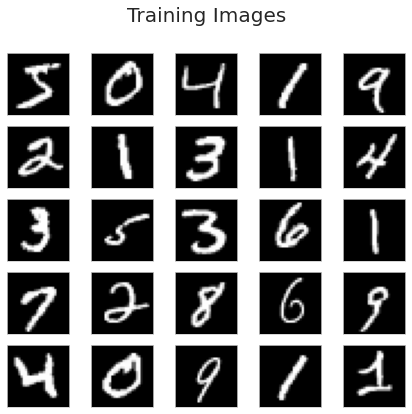

In [9]:
plot(X_train, "Training Images")

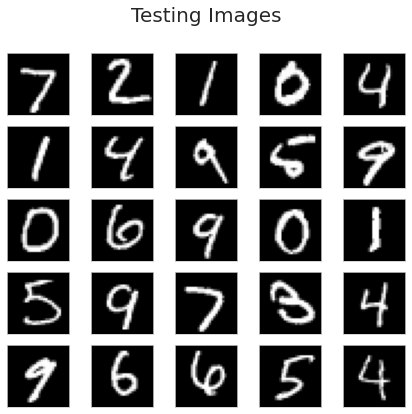

In [10]:
plot(X_test, "Testing Images")

## PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
n_dim=2

In [0]:
pca = PCA(n_components=n_dim)

In [0]:
X_pca = pca.fit(X_train)

In [0]:
X_test_pca = pca.transform(X_test)

In [0]:
X_test_pca = matmul(X_test_pca, pca.components_).numpy()

In [17]:
X_test.shape, X_test_pca.shape

((10000, 784), (10000, 784))

**Explained Variance**

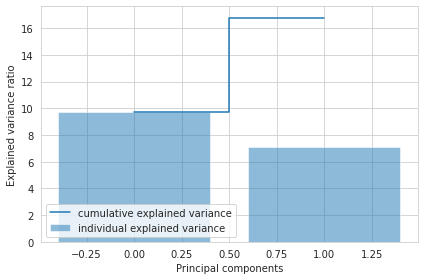

In [18]:
plt.figure(figsize=(6, 4))
plt.bar(range(n_dim), pca.explained_variance_ratio_*100, 
        alpha=0.5, align='center', label='individual explained variance')
plt.step(range(n_dim), np.cumsum(pca.explained_variance_ratio_*100), where='mid',
             label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

**Reconstruction on Test Image**

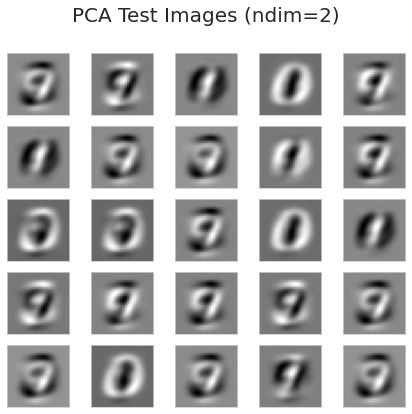

In [19]:
plot(X_test_pca, f"PCA Test Images (ndim={n_dim})")

In [0]:
error = np.sum(mean_squared_error(X_test, X_test_pca))

In [21]:
print(f"Reconstruction Error (PCA): {error}")

Reconstruction Error (PCA): 1015.9780897279466


**Latent Space Visualization**

In [0]:
X_latent_pca = pca.transform(X_test)

In [0]:
df1 = pd.DataFrame(X_latent_pca, columns=["Dim1", "Dim2"])
df1["Value"] = y_test

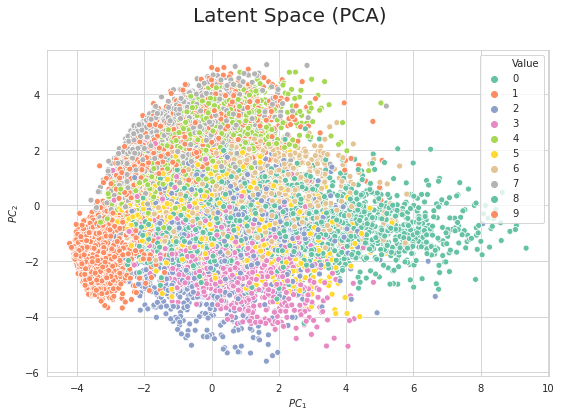

In [24]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(x="Dim1", y="Dim2", hue="Value", palette="Set2", legend="full", data=df1)
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
fig.suptitle("Latent Space (PCA)", fontsize=20)
plt.show()

## Linear AutoEncoder

A single layered autoencoder with a linear activation function is very similar to PCA.

In [0]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [0]:
input_img = Input(shape=(784,))
# ENCODER
encoder = Dense(512, activation="linear")(input_img)
encoder = Dense(128, activation="linear")(encoder)
# BottleNeck
bottleneck = Dense(n_dim, activation='linear')(encoder)
# DECODER
decoder = Dense(128, activation="linear")(bottleneck)
decoder = Dense(512, activation="linear")(bottleneck)
decoder = Dense(784, activation='linear')(decoder)

In [0]:
autoencoder = Model(input_img, decoder)

In [0]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
history = autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=256,
                shuffle=True)

Epoch 1/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0613
Epoch 2/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0574
Epoch 3/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0564
Epoch 4/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0561
Epoch 5/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0561


In [0]:
X_test_autoencoder = autoencoder.predict(X_test)

In [31]:
X_test.shape, X_test_autoencoder.shape

((10000, 784), (10000, 784))

**Reconstruction on Test Image**

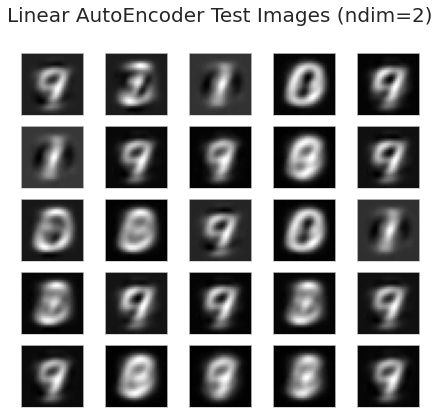

In [32]:
plot(X_test_autoencoder, f"Linear AutoEncoder Test Images (ndim={n_dim})")

In [0]:
error = np.sum(mean_squared_error(X_test, X_test_autoencoder))

In [34]:
print(f"Reconstruction Error (Linear AutoEncoder): {error}")

Reconstruction Error (Linear AutoEncoder): 557.8199462890625


**Latent Space Visualization**

In [0]:
encoder = Model(input_img, bottleneck)

In [0]:
X_latent_autoencoder = encoder(X_test)

In [0]:
df2 = pd.DataFrame(X_latent_autoencoder.numpy(), columns=["Dim1", "Dim2"])
df2["Value"] = y_test

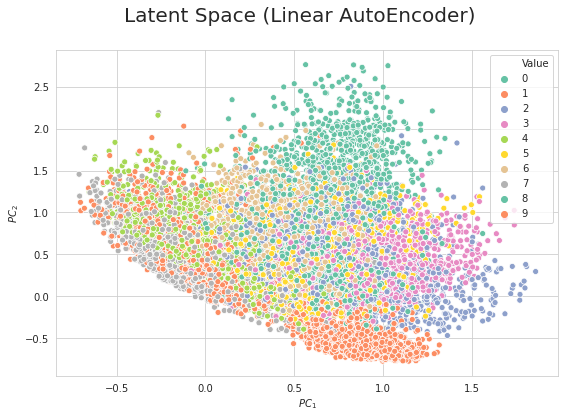

In [38]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(x="Dim1", y="Dim2", hue="Value", palette="Set2", legend="full", data=df2)
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
fig.suptitle("Latent Space (Linear AutoEncoder)", fontsize=20)
plt.show()

A single layer auto encoder with linear transfer function is nearly equivalent to PCA, where nearly means that the $W$ found by AE and PCA won't necessarily be the same - but ***the subspace spanned by the respective $W's$ will be same***.

## AutoEncoder

Here, I build an AutoEncoder with non-linear activation functions.  If the ***features have non-linear relationship with each other than autoencoder will be able to compress the information better*** into low dimensional latent space leveraging its capability to model complex non-linear functions.

In [0]:
input_img = Input(shape=(784,))
# ENCODER
encoder = Dense(512, activation="relu")(input_img)
encoder = Dense(128, activation="relu")(encoder)
# BottleNeck
bottleneck = Dense(n_dim, activation='linear')(encoder)
# DECODER
decoder = Dense(128, activation="relu")(bottleneck)
decoder = Dense(512, activation="relu")(bottleneck)
decoder = Dense(784, activation='sigmoid')(decoder)

In [0]:
autoencoder = Model(input_img, decoder)

In [0]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
history = autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=256,
                shuffle=True)

Epoch 1/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0678
Epoch 2/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0512
Epoch 3/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0476
Epoch 4/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0460
Epoch 5/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0449


In [0]:
X_test_autoencoder = autoencoder.predict(X_test)

In [44]:
X_test.shape, X_test_autoencoder.shape

((10000, 784), (10000, 784))

**Reconstruction on Test Image**

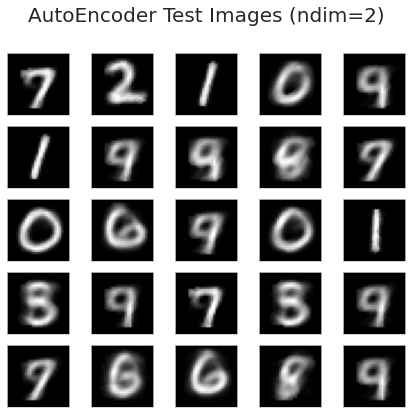

In [45]:
plot(X_test_autoencoder, f"AutoEncoder Test Images (ndim={n_dim})")

In [0]:
error = np.sum(mean_squared_error(X_test, X_test_autoencoder))

In [47]:
print(f"Reconstruction Error (AutoEncoder): {error}")

Reconstruction Error (AutoEncoder): 442.79351806640625


**As expected, an autoencoder with non-linear activation function performs better than a linear autoencoder**

**Latent Space Visualization**

In [0]:
encoder = Model(input_img, bottleneck)

In [0]:
X_latent_autoencoder = encoder(X_test)

In [0]:
df3 = pd.DataFrame(X_latent_autoencoder.numpy(), columns=["Dim1", "Dim2"])
df3["Value"] = y_test

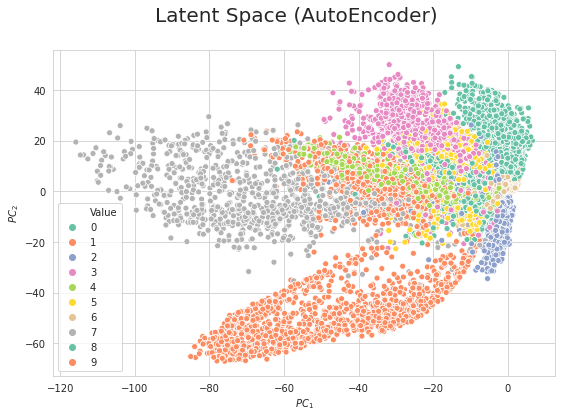

In [51]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(x="Dim1", y="Dim2", hue="Value", legend="full", palette="Set2", data=df3)
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
fig.suptitle("Latent Space (AutoEncoder)", fontsize=20)
plt.show()

**Looks, like it performs a better seperation between classes as compared to the previous 2 plots**

***Unlike in PCA, for AutoEncoders with non-linear activation, features in latent space are not orthogonal to each other, hence it doesn't make much sense plotting and visualizing them.***

But here I've visualized it anyways. For the sake of closure 😛

## AutoEncoder (ndim=10)

Let's try the above model within number of hidden dimensions in bottleneck layer as 10

In [0]:
n_dim=10

In [0]:
input_img = Input(shape=(784,))
# ENCODER
encoder = Dense(512, activation="linear")(input_img)
encoder = Dense(128, activation="linear")(encoder)
# BottleNeck
bottleneck = Dense(n_dim, activation='linear')(encoder)
# DECODER
decoder = Dense(128, activation="linear")(bottleneck)
decoder = Dense(512, activation="linear")(bottleneck)
decoder = Dense(784, activation='sigmoid')(decoder)

In [0]:
autoencoder = Model(input_img, decoder)

In [0]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
history = autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=256,
                shuffle=True)

Epoch 1/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0476
Epoch 2/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0320
Epoch 3/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0315
Epoch 4/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0314
Epoch 5/5
235/235 [==============================] - 1s 3ms/step - loss: 0.0312


In [0]:
X_test_autoencoder = autoencoder.predict(X_test)

In [58]:
X_test.shape, X_test_autoencoder.shape

((10000, 784), (10000, 784))

**Reconstruction on Test Image**

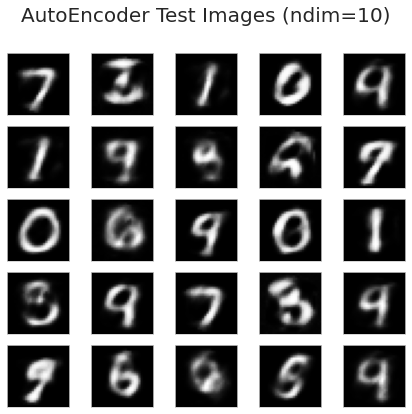

In [59]:
plot(X_test_autoencoder, f"AutoEncoder Test Images (ndim={n_dim})")

In [0]:
error = np.sum(mean_squared_error(X_test, X_test_autoencoder))

In [61]:
print(f"Reconstruction Error (AutoEncoder): {error}")

Reconstruction Error (AutoEncoder): 305.92742919921875


**Reconstruction Loss has reduced significantly.** It has reduced by more than half. 

**Latent Space Visualization**

In [0]:
encoder = Model(input_img, bottleneck)

In [0]:
X_latent_autoencoder = encoder(X_test)

In [0]:
df4 = pd.DataFrame(X_latent_autoencoder.numpy(), columns=["Dim"+str(x) for x in range(n_dim)])
df4["Value"] = y_test

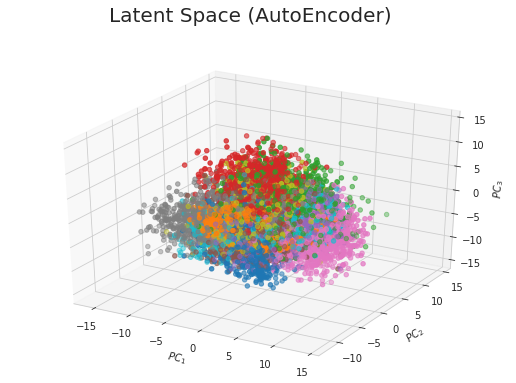

In [65]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
colors = list(sns.color_palette())
ax.scatter(df4['Dim1'], df4['Dim2'], df4['Dim3'], c=df4['Value'].apply(lambda x: colors[x]))
ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
ax.set_zlabel('$PC_3$')
fig.suptitle("Latent Space (AutoEncoder)", fontsize=20)
plt.show()

## Convolutional AutoEncoder

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
X_train = X_train.astype("float")/255.0
X_test = X_test.astype("float")/255.0

In [0]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [0]:
input_ = Input(shape=(28, 28, 1))

**Encoder**

In [0]:
img = Conv2D(32, (3, 3), activation="relu", padding="same")(input_)
img = MaxPooling2D((2, 2), padding="same")(img)
img = Conv2D(16, (3, 3), activation="relu", padding="same")(img)
img = MaxPooling2D((2, 2), padding="same")(img)
img = Conv2D(8, (3, 3), activation="relu", padding="same")(img)
bottleneck = MaxPooling2D((2, 2), padding="same")(img)

In [0]:
encoder = Model(input_, bottleneck, name="Encoder")

**Decoder**

In [0]:
img = Conv2D(8, (3, 3), activation="relu", padding="same")(bottleneck)
img = UpSampling2D((2, 2))(img)
img = Conv2D(16, (3, 3), activation="relu", padding="same")(img)
img = UpSampling2D((2, 2))(img)
img = Conv2D(32, (3, 3), activation="relu")(img)
img = UpSampling2D((2, 2))(img)
out = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(img)

**AutoEncoder**

In [0]:
autoencoder = Model(input_, out)

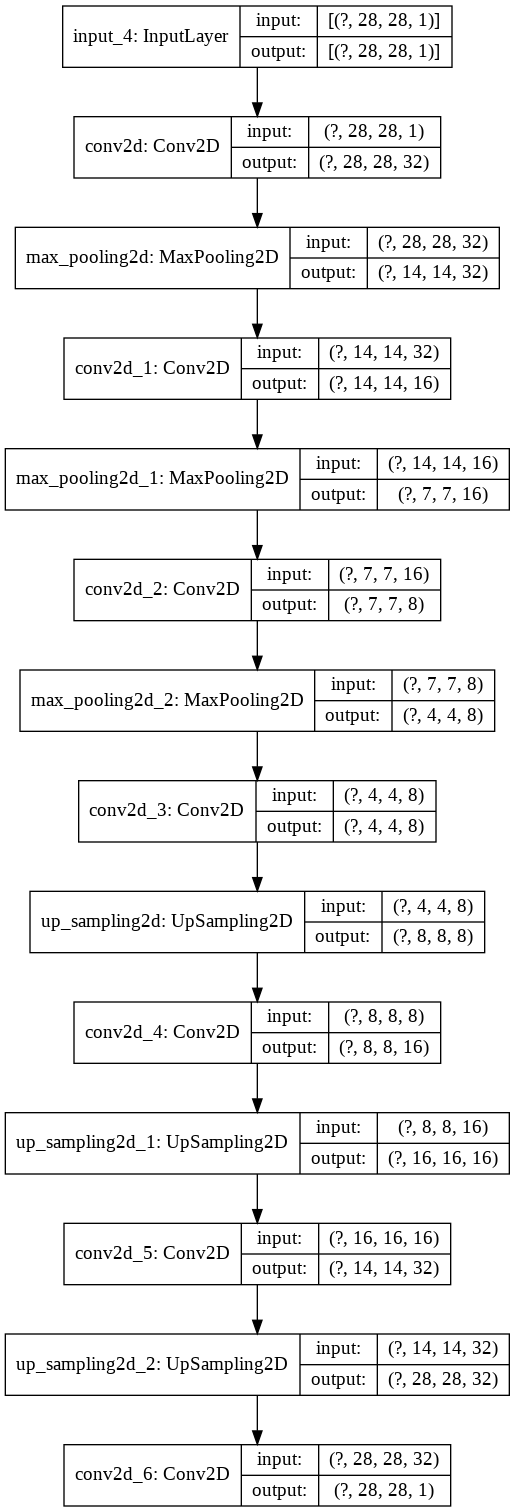

In [75]:
plot_model(autoencoder, show_shapes=True)

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
history = autoencoder.fit(X_train, X_train,
               epochs=50,
               batch_size=256,
               shuffle=True)

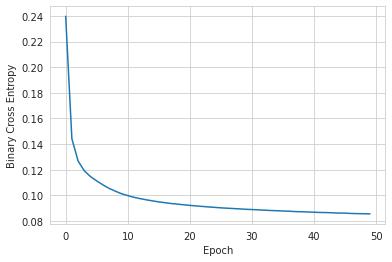

In [78]:
plt.plot(history.history['loss'])
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [0]:
X_test_conv_ae = autoencoder.predict(X_test)

In [0]:
X_test_conv_ae = X_test_conv_ae.reshape(10000, 28, 28)

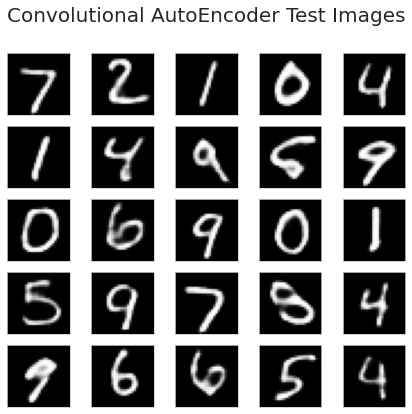

In [81]:
plot(X_test_conv_ae, f"Convolutional AutoEncoder Test Images")